In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [23]:
plt.rcParams["figure.figsize"] = (16, 7)

# Loading the data

Let's start by loading the data in pandas dataframes.

## Campaign desc

In [56]:
df_campaign_desc = pd.read_csv('dunnhumby/campaign_desc.csv')

In [32]:
df_campaign_desc.head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [7]:
print('Number of campaign: ', len(df_campaign_desc.CAMPAIGN))
print('Unique description: ', df_campaign_desc.DESCRIPTION.sort_values().unique())

Number of campaign:  30
Unique description:  ['TypeA' 'TypeB' 'TypeC']


Let's add a column with the duration of each campaign

In [3]:
df_campaign_desc['DURATION'] = df_campaign_desc['END_DAY'] - df_campaign_desc['START_DAY'] 
df_campaign_desc.sort_values(by = ['DESCRIPTION', 'DURATION'])

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,DURATION
29,TypeA,26,224,264,40
25,TypeA,30,323,369,46
12,TypeA,13,504,551,47
17,TypeA,8,412,460,48
7,TypeA,18,587,642,55
2,TypeB,25,659,691,32
5,TypeB,21,624,656,32
6,TypeB,22,624,656,32
8,TypeB,19,603,635,32
9,TypeB,17,575,607,32


Let's have some statistics for each type of campaign.

In [35]:
for camp in ['TypeA', 'TypeB', 'TypeC']:
    print('Campaigns of %s range between %d and %d days' %(camp, df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.min(),
                                                     df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.max()))
    print('with a mean duration of %.2f days and a median duration of %.2f days.' 
            %(df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.mean(),
              df_campaign_desc[df_campaign_desc.DESCRIPTION == camp].DURATION.median()))

Campaigns of TypeA range between 40 and 55 days
with a mean duration of 47.20 days and a median duration of 47.00 days.
Campaigns of TypeB range between 32 and 61 days
with a mean duration of 37.63 days and a median duration of 32.00 days.
Campaigns of TypeC range between 32 and 161 days
with a mean duration of 74.50 days and a median duration of 64.00 days.


We observe these campaigns does not last the same amount of days. Notice in particular there is one campaign of type C lasting 161 days. We will look at the number of coupons distributed during this particular campaign to see what happened.

## Campaign table

In [8]:
df_campaign_table = pd.read_csv('dunnhumby/campaign_table.csv')

In [37]:
df_campaign_table.head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


Let's study the distribution of the number of campaigns each household has benefited from.

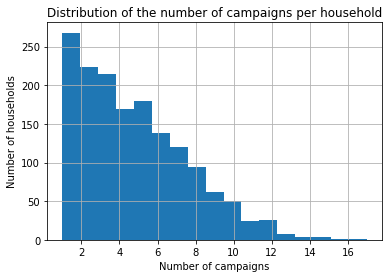

In [9]:
nbins = df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().max()
df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().hist(bins = nbins)
plt.title('Distribution of the number of campaigns per household')
plt.xlabel('Number of campaigns')
plt.ylabel('Number of households')
plt.show()

In [10]:
print('Mean number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().mean())
print('Median number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().median())
print('Max number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().max())
print('25% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.25),
      'campaigns or less.')
print('75% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.75),
      'campaigns or less.')
print('95% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.95),
      'campaigns or less.')

Mean number of campaigns: 4.55050505050505
Median number of campaigns: 4.0
Max number of campaigns: 17
25% of the households have benefited from 2.0 campaigns or less.
75% of the households have benefited from 6.0 campaigns or less.
95% of the households have benefited from 10.0 campaigns or less.


## Causal data

In [11]:
df_causal = pd.read_csv('dunnhumby/causal_data.csv')

In [26]:
df_causal.head()

,PRODUCT_ID,STORE_ID,WEEK_NO,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A
2,26190,289,70,0,A
3,26190,292,70,0,A
4,26190,293,70,0,A


Let's define two dict for the code meaning of display and mailer.

In [14]:
display_dict = {0:'Not on Display', 1:'Store Front', 2:'Store Rear', 3:'Front End Cap',
                4:'Mid-Aisle End Cap', 5:'Read End Cap' ,6:'Side-Aisle End Cap', 7:'In-Aisle' ,
                9:'Secondary Location Display' ,'A':'In-Shelf' }
mailer_dict = {0:'Not on ad', 'A':'Interior page feature', 'C':'Interior page line item', 
              'D':'Front page feature', 'F':'Back page feature', 'H':'Wrap front feature',
              'J':'Wrap interior coupon', 'L':'Wrap back feature', 'P':'Interior page coupon',
              'X':'Free on interior page', 'Z':'Free on front page, back page or wrap'}

## Coupon redemption

In [9]:
df_coupon_redempt = pd.read_csv('dunnhumby/coupon_redempt.csv')

In [39]:
df_coupon_redempt.head()

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


Let's study how many coupons were redeemed for each campaign.

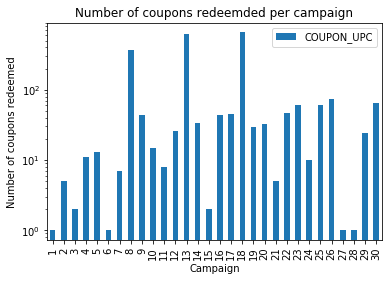

In [40]:
df_coupon_redempt.groupby(by = 'CAMPAIGN').count().plot.bar(y = 'COUPON_UPC', logy = True) 
plt.xlabel('Campaign')
plt.ylabel('Number of coupons redeemed')
plt.title('Number of coupons redeemded per campaign')
plt.show()

## Coupon

In [10]:
df_coupon = pd.read_csv('dunnhumby/coupon.csv')

In [42]:
df_coupon.head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


Let's study how many coupons were distributed for each campaign.

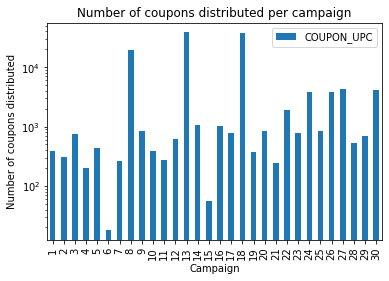

In [43]:
df_coupon.groupby(by = 'CAMPAIGN').count().plot.bar(y = 'COUPON_UPC', logy = True) 
plt.xlabel('Campaign')
plt.ylabel('Number of coupons distributed')
plt.title('Number of coupons distributed per campaign')
plt.show()

We notice there are definetely some campaigns with way more coupons than others. Is this related to the type of campaign?

Let's add a column stating if a coupon has been redeemed or not.

In [11]:
df_coupon['REDEEMED'] = df_coupon['COUPON_UPC'].isin(df_coupon_redempt['COUPON_UPC'])
df_coupon.head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN,REDEEMED
0,10000089061,27160,4,False
1,10000089064,27754,9,True
2,10000089073,28897,12,True
3,51800009050,28919,28,True
4,52100000076,28929,25,True


We can now observe the number of coupons that were not redeemed for each campaign.

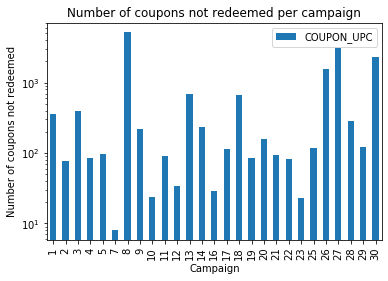

In [45]:
df_coupon[~df_coupon['REDEEMED']].groupby(by = 'CAMPAIGN').count().plot.bar(y = 'COUPON_UPC', logy = True) 
plt.xlabel('Campaign')
plt.ylabel('Number of coupons not redeemed')
plt.title('Number of coupons not redeemed per campaign')
plt.show()

## Demographics

In [12]:
df_demo = pd.read_csv('dunnhumby/hh_demographic.csv')

In [34]:
df_demo.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


## Products

In [2]:
df_products = pd.read_csv('dunnhumby/product.csv')

In [3]:
df_products.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [10]:
print('There are %d different commodity categories.' %len(df_products['COMMODITY_DESC'].unique()))

There are 308 different commodity categories.


In [14]:
df_products['COMMODITY_DESC'].unique()

array(['FRZN ICE', 'NO COMMODITY DESCRIPTION', 'BREAD',
       'FRUIT - SHELF STABLE', 'COOKIES/CONES', 'SPICES & EXTRACTS',
       'VITAMINS', 'BREAKFAST SWEETS', 'PNT BTR/JELLY/JAMS',
       'ICE CREAM/MILK/SHERBTS', 'MAGAZINE', 'AIR CARE', 'CHEESE',
       'SHORTENING/OIL', 'COFFEE', 'DIETARY AID PRODUCTS',
       'PAPER HOUSEWARES', 'BAKED BREAD/BUNS/ROLLS',
       'VEGETABLES - SHELF STABLE', 'HISPANIC', 'DINNER MXS:DRY',
       'CONDIMENTS/SAUCES', 'FRZN VEGETABLE/VEG DSH', 'BAKING NEEDS',
       'DINNER SAUSAGE', 'FRZN FRUITS', 'SEAFOOD - FROZEN',
       'HOUSEHOLD CLEANG NEEDS', 'FD WRAPS/BAGS/TRSH BG',
       'DRY MIX DESSERTS', 'PICKLE/RELISH/PKLD VEG', 'CAKES',
       'BAKING MIXES', 'POTATOES', 'FLUID MILK PRODUCTS', 'SOUP',
       'BAKED SWEET GOODS', 'COOKIES', 'DRY BN/VEG/POTATO/RICE',
       'FACIAL TISS/DNR NAPKIN', 'FROZEN PIZZA', 'EGGS',
       'REFRGRATD DOUGH PRODUCTS', 'HOT CEREAL', 'COLD CEREAL',
       'SUGARS/SWEETNERS', 'SEAFOOD - SHELF STABLE', 'POPCORN',
   

In [16]:
df_products['DEPARTMENT'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

## Transaction data

In [37]:
df_transaction = pd.read_csv('dunnhumby/transaction_data.csv')

In [38]:
df_transaction.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


Let's precise what does the less obvious column represent. The SALES_VALUE is the amount of dollar received by the retailer for a particular sale. The RETAIL_DISC is a discount applied due to retailer's loyalty card program. The COUPON_DISC is a discount applied due to manufacturer coupon and COUPON_MATCH_DISC a discount applied due to retailer's match of manufacturer coupon. Finally, the TRANS_TIME correspond to the time of the day the purchase was made (ranging from 0 to 2359, i.e. from 0:00 to 23:59)

In [39]:
print('The TRANS_TIME ranges between %d and %d.' %(df_transaction['TRANS_TIME'].min(), df_transaction['TRANS_TIME'].max()))

The TRANS_TIME ranges between 0 and 2359.


Let's add the actual product prices (with or without loyalty card). To do so, we use the following formulas (as explained in the user guide):  
    - Loyalty card price = (sales_value – (retail_disc + coupon_match_disc))/quantity  
    - Non-loyalty card price = (sales_value – (coupon_match_disc))/quantity 
    

In [40]:
df_transaction['LOYALTY_CARD_PRICE'] = (df_transaction['SALES_VALUE'] - (df_transaction['RETAIL_DISC'] + df_transaction['COUPON_MATCH_DISC']))/df_transaction['QUANTITY']
df_transaction['NO_LOYALTY_CARD_PRICE'] = (df_transaction['SALES_VALUE'] - df_transaction['COUPON_MATCH_DISC'])/df_transaction['QUANTITY']
df_transaction.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,LOYALTY_CARD_PRICE,NO_LOYALTY_CARD_PRICE
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.99,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,1.29,0.99
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.89,1.50


# Campaign analysis 

In this section, we try to do a more thorough analysis of the campaigns.

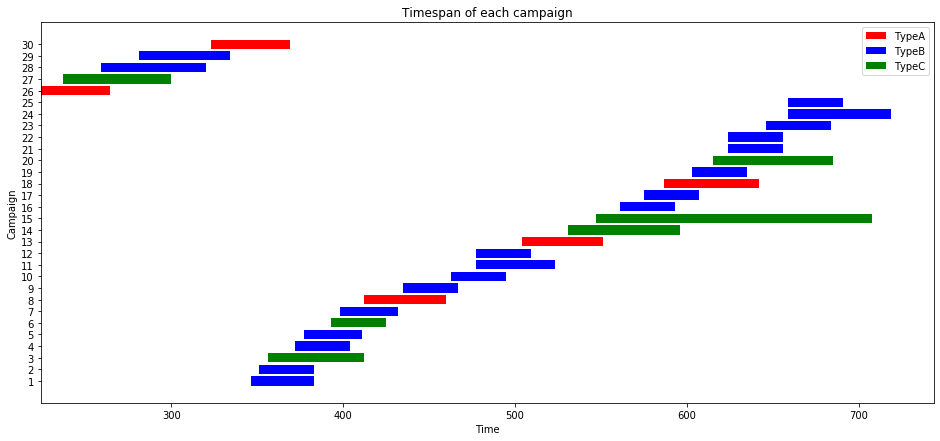

In [109]:
#Split the datas per campaign type for better visualization
beginA = df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeA']['START_DAY'].values
endA =   df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeA']['END_DAY'].values
beginB = df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeB']['START_DAY'].values
endB =   df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeB']['END_DAY'].values
beginC = df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeC']['START_DAY'].values
endC =   df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeC']['END_DAY'].values

#Plot the timespan of each campaign
plt.barh(df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeA'].index.values,  endA-beginA, left=beginA, 
         color = 'red', label = 'TypeA')
plt.barh(df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeB'].index.values,  endB-beginB, left=beginB, 
         color = 'blue', label = 'TypeB')
plt.barh(df_campaign_desc[df_campaign_desc.DESCRIPTION == 'TypeC'].index.values,  endC-beginC, left=beginC, 
         color = 'green', label = 'TypeC')

#Add title & legend
plt.title('Timespan of each campaign')
plt.ylabel('Campaign')
plt.yticks(df_campaign_desc.index)
plt.xlabel('Time')
plt.legend()
plt.show()

Now, let's complete the campaign dataframe with informations from other tables.

In [78]:
df_campaign_desc.sort_values(by = 'CAMPAIGN', inplace = True)
df_campaign_desc.set_index(keys = 'CAMPAIGN', drop = True, inplace = True)
df_campaign_desc['DISTRIBUTED'] = df_coupon.groupby(by = 'CAMPAIGN').REDEEMED.count() #Number of coupons distributed
df_campaign_desc['REDEEMED'] = df_coupon[~df_coupon['REDEEMED']].groupby(by = 'CAMPAIGN').REDEEMED.count() #Number of coupons redeemed
df_campaign_desc.fillna(0, inplace = True) 
df_campaign_desc['BENEFICIARY'] = df_campaign_table.groupby(by = 'CAMPAIGN').DESCRIPTION.count() #Number of beneficiary households
df_campaign_desc.head()

,DESCRIPTION,START_DAY,END_DAY,DISTRIBUTED,REDEEMED,BENEFICIARY
CAMPAIGN,,,,,,
1,TypeB,346,383,383,363.0,13
2,TypeB,351,383,301,78.0,48
3,TypeC,356,412,740,392.0,12
4,TypeB,372,404,200,84.0,81
5,TypeB,377,411,443,97.0,166


Let's observe these results in a bar plot. For each campaign we plot the amount of coupon distributed and redeemed, and we add the type of the campaign.

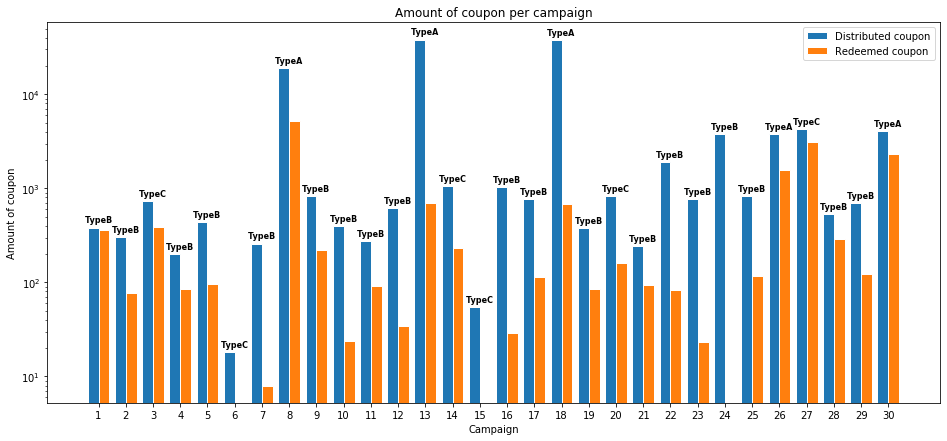

In [82]:
# set width of bar
barWidth = 0.4
 
# set height of bar
coupon_distributed = df_campaign_desc['DISTRIBUTED']
coupon_redeemed = df_campaign_desc['REDEEMED']
 
# Set position of bar on X axis
r = np.arange(len(bars1)+1)
r1 = [x - barWidth/2 for x in r[1:]]
r2 = [x + barWidth/2 for x in r[1:]]
 
# Make the plot
plt.bar(r1, coupon_distributed, width=barWidth, edgecolor='white', label='Distributed coupon')
plt.bar(r2, coupon_redeemed, width=barWidth, edgecolor='white', label='Redeemed coupon')
plt.yscale('log') #Better visualizations because very different amounts of coupon between campaign
 
# Attach a text label above each bar in *bars*, displaying the campaign type
type_c = df_campaign_desc.DESCRIPTION.values
for i in range(len(coupon_distributed.values)):    
    plt.annotate('{}'.format(type_c[i]),
                xy=(r[i+1], coupon_distributed.values[i]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontweight = 'bold',
                fontsize = 8)
  
    
# Add title and legend
plt.title('Amount of coupon per campaign')
plt.xlabel('Campaign')
plt.xticks(df_campaign_desc.index)
plt.ylabel('Amount of coupon')
plt.legend()
plt.show()